In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, MACCSkeys, AllChem

import warnings
warnings.filterwarnings('ignore')


In [7]:

print("데이터 로딩 중...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"훈련 데이터 : {train.shape}")
print(f"테스트 데이터 : {test.shape}")

데이터 로딩 중...
훈련 데이터 : (1681, 3)
테스트 데이터 : (100, 2)


In [8]:

def get_molecule_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0] * 2232

        basic_descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.NumAliphaticRings(mol),
            Lipinski.NumAromaticHeterocycles(mol),
            Lipinski.NumSaturatedHeterocycles(mol),
            Lipinski.NumAliphaticHeterocycles(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.RingCount(mol),
            Descriptors.NOCount(mol),
            Descriptors.NHOHCount(mol),
            Descriptors.NumRadicalElectrons(mol),
        ]

        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        morgan_features = [int(bit) for bit in morgan_fp.ToBitString()]

        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        maccs_features = [int(bit) for bit in maccs_fp.ToBitString()]

        all_features = basic_descriptors + morgan_features + maccs_features

        return all_features
    except:
        return [0] * 2232


## 분자 특성 추출 및 데이터 전처리 과정

이 단계에서는 SMILES 문자열을 분자 특성으로 변환하고, 머신러닝 모델에 입력할 수 있는 형태로 데이터를 준비합니다.

### 처리 과정:
1. **특성 추출**: 각 SMILES를 2232차원의 특성 벡터로 변환
2. **길이 통일**: 모든 특성 벡터의 길이를 동일하게 맞춤
3. **배열 변환**: 리스트를 NumPy 배열로 변환
4. **차원 정합**: 훈련/테스트 데이터의 특성 차원을 일치시킴

In [ ]:
print("분자 특성 추출 중...")

# 1. 훈련 데이터 특성 추출
# SMILES를 분자 특성으로 변환 (각 행에 대해 get_molecule_descriptors 함수 적용)
train['features'] = train['Canonical_Smiles'].apply(get_molecule_descriptors)

# 2. 훈련 데이터 길이 통일
# features 컬럼의 리스트들을 파이썬 리스트로 변환
X_train_list = train['features'].tolist()
# 각 특성 벡터의 길이 확인
feature_lengths = [len(x) for x in X_train_list]

# 만약 특성 벡터들의 길이가 다르다면 (이론적으로는 모두 2232여야 함)
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    # 짧은 벡터들을 0으로 패딩하여 길이를 맞춤
    X_train_list = [x + [0] * (max_length - len(x)) for x in X_train_list]

# 3. NumPy 배열로 변환
X_train = np.array(X_train_list)  # (샘플 수, 특성 수) 형태의 2D 배열
y_train = train['Inhibition'].values  # 타겟 변수

# 4. 테스트 데이터 특성 추출 (훈련 데이터와 동일한 과정)
test['features'] = test['Canonical_Smiles'].apply(get_molecule_descriptors)
X_test_list = test['features'].tolist()
feature_lengths = [len(x) for x in X_test_list]

# 테스트 데이터도 길이 통일
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    X_test_list = [x + [0] * (max_length - len(x)) for x in X_test_list]

# 5. 훈련/테스트 데이터 간 차원 정합
# 만약 훈련과 테스트 데이터의 특성 수가 다르다면
if X_train.shape[1] != len(X_test_list[0]):
    diff = abs(X_train.shape[1] - len(X_test_list[0]))
    if X_train.shape[1] > len(X_test_list[0]):
        # 훈련 데이터가 더 크면 테스트 데이터를 패딩
        X_test_list = [x + [0] * diff for x in X_test_list]
    else:
        # 테스트 데이터가 더 크면 훈련 데이터를 패딩
        X_train = np.array([x.tolist() + [0] * diff for x in X_train])

# 6. 최종 테스트 데이터 배열 변환
X_test = np.array(X_test_list)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 {X_train.shape[1]}개")


분자 특성 추출 중...


[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerator
[13:14:05] DEPRECATION WARNING: please use MorganGenerat

X_train: (1681, 2233), X_test: (100, 2233)


[13:14:10] DEPRECATION WARNING: please use MorganGenerator
[13:14:10] DEPRECATION WARNING: please use MorganGenerator
[13:14:10] DEPRECATION WARNING: please use MorganGenerator
[13:14:10] DEPRECATION WARNING: please use MorganGenerator


In [10]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)


In [11]:

def normalized_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true) - np.min(y_true))

def pearson_correlation(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return np.clip(corr, 0, 1)

def competition_score(y_true, y_pred):
    nrmse = min(normalized_rmse(y_true, y_pred), 1)
    pearson = pearson_correlation(y_true, y_pred)
    return 0.5 * (1 - nrmse) + 0.5 * pearson

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_nrmse = normalized_rmse(y_val, y_val_pred)
    val_pearson = pearson_correlation(y_val, y_val_pred)
    val_score = competition_score(y_val, y_val_pred)
    print(f"검증 NRMSE: {val_nrmse:.4f}")
    print(f"검증 Pearson: {val_pearson:.4f}")
    print(f"검증 점수: {val_score:.4f}")
    return model, val_score


In [12]:

models = {
    "XGBoost": xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, gamma=0,
        reg_alpha=0.1, reg_lambda=1, random_state=42
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=500, learning_rate=0.05, num_leaves=31,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.1, reg_lambda=1, random_state=42
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=5,
        min_samples_split=5, min_samples_leaf=2, subsample=0.8,
        random_state=42
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42
    )
}

best_score = -np.inf
best_model_name = None
trained_models = {}

for name, model in models.items():
    print(f"\n{name} 모델 학습 중...")
    trained_model, val_score = train_and_evaluate_model(
        model, X_train_final, y_train_final, X_val, y_val
    )
    trained_models[name] = trained_model
    if val_score > best_score:
        best_score = val_score
        best_model_name = name

print(f"\n최고 성능 모델: {best_model_name}, 검증 점수: {best_score:.4f}")



XGBoost 모델 학습 중...
검증 NRMSE: 0.2329
검증 Pearson: 0.4870
검증 점수: 0.6270

LightGBM 모델 학습 중...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3260
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 755
[LightGBM] [Info] Start training from score 33.391242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [13]:

final_model = models[best_model_name]
final_model.fit(X_train_scaled, y_train)

test_preds = final_model.predict(X_test_scaled)

submission['Inhibition'] = test_preds
submission.to_csv('improved_submission.csv', index=False)
print("예측 결과 저장: improved_submission.csv")


예측 결과 저장: improved_submission.csv


모델 성능 시각화 저장: model_performance.png
특성 중요도 시각화 저장: feature_importance.png


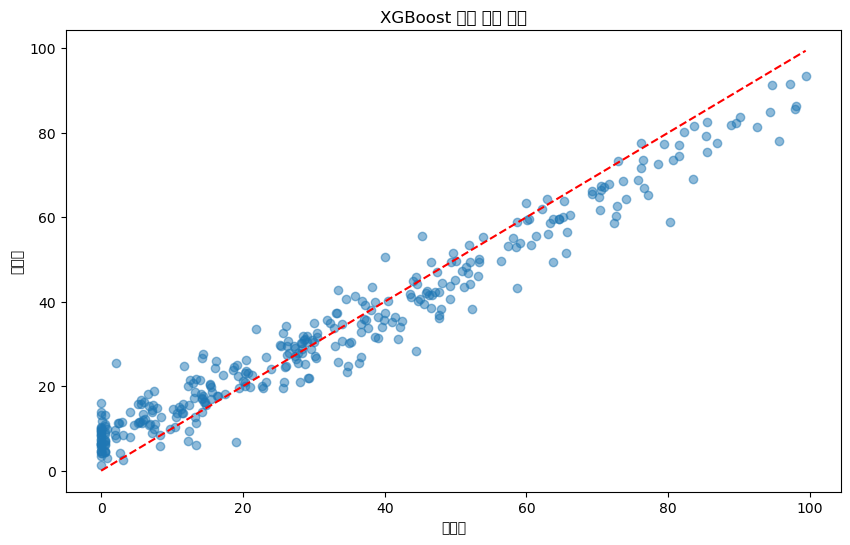

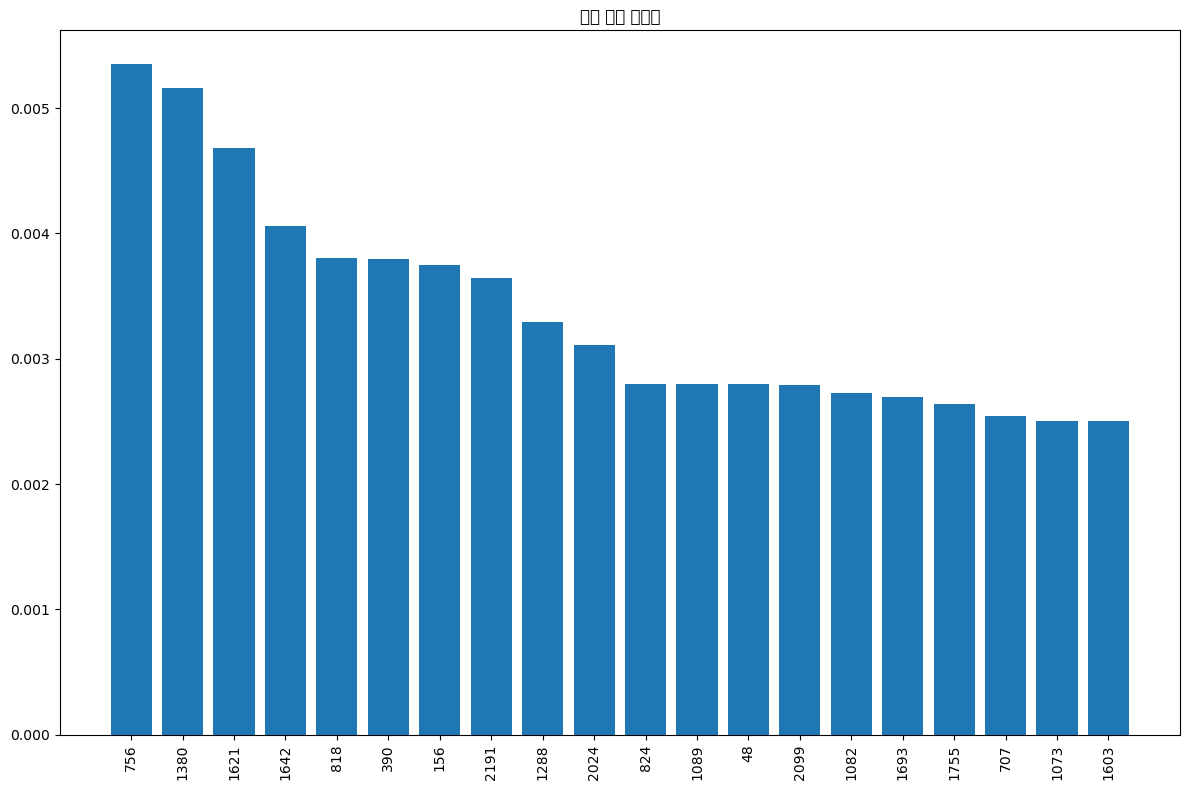

In [14]:

plt.figure(figsize=(10, 6))
y_val_pred = trained_models[best_model_name].predict(X_val)
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title(f'{best_model_name} 모델 검증 성능')
plt.savefig('model_performance.png')
print("모델 성능 시각화 저장: model_performance.png")

if hasattr(final_model, 'feature_importances_'):
    n_features = 20
    importances = final_model.feature_importances_
    indices = np.argsort(importances)[::-1][:n_features]
    plt.figure(figsize=(12, 8))
    plt.title('상위 특성 중요도')
    plt.bar(range(n_features), importances[indices])
    plt.xticks(range(n_features), indices, rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("특성 중요도 시각화 저장: feature_importance.png")
